<a href="https://colab.research.google.com/github/AmalPrakash/BEETHOVEN-SIGN-LANGUAGE-ASSISTANT/blob/master/Beethoventrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [ ]:
base_dir = "/content/gdrive/My Drive/Train"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
IMAGE_SIZE =96
BATCH_SIZE=64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'training',
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'validation',
)

Found 6163 images belonging to 3 classes.
Found 1539 images belonging to 3 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 96, 96, 3), (64, 3))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Evening': 0, 'Good': 1, 'Morning': 2}


In [ ]:
!cat labels.txt

Evening
Good
Morning

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 2,626,755
Trainable params: 368,771
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [ ]:
epochs = 10

history = model.fit(train_generator, 
                     steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
97/97 [==============================] - 975s 10s/step - loss: 0.0908 - accuracy: 0.9651 - val_loss: 0.0252 - val_accuracy: 0.9877
Epoch 2/10
97/97 [==============================] - 49s 508ms/step - loss: 0.0080 - accuracy: 0.9974 - val_loss: 0.0519 - val_accuracy: 0.9838
Epoch 3/10
97/97 [==============================] - 49s 505ms/step - loss: 0.0100 - accuracy: 0.9977 - val_loss: 0.0749 - val_accuracy: 0.9812
Epoch 4/10
97/97 [==============================] - 52s 541ms/step - loss: 0.0049 - accuracy: 0.9981 - val_loss: 0.0602 - val_accuracy: 0.9786
Epoch 5/10
97/97 [==============================] - 50s 514ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0852 - val_accuracy: 0.9779
Epoch 6/10
97/97 [==============================] - 50s 515ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0989 - val_accuracy: 0.9786
Epoch 7/10
97/97 [==============================] - 50s 511ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.1202 - val_accuracy: 0.9799


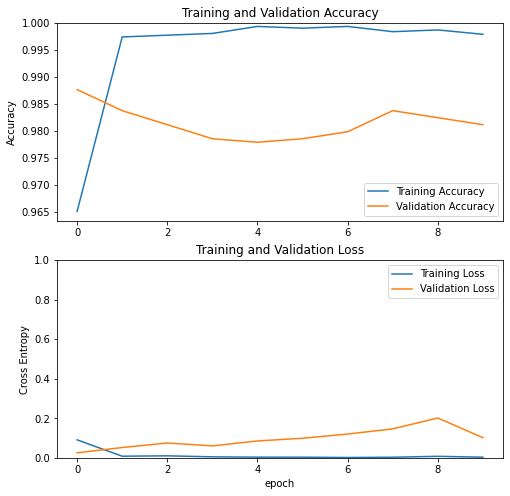

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 2,626,755
Trainable params: 2,231,363
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [ ]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=10, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/10
97/97 [==============================] - 90s 923ms/step - loss: 0.2290 - accuracy: 0.9482 - val_loss: 0.1129 - val_accuracy: 0.9818
Epoch 2/10
97/97 [==============================] - 93s 954ms/step - loss: 0.0243 - accuracy: 0.9922 - val_loss: 0.1234 - val_accuracy: 0.9812
Epoch 3/10
97/97 [==============================] - 89s 915ms/step - loss: 0.0120 - accuracy: 0.9966 - val_loss: 0.1424 - val_accuracy: 0.9825
Epoch 4/10
97/97 [==============================] - 89s 916ms/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.1559 - val_accuracy: 0.9825
Epoch 5/10
97/97 [==============================] - 89s 916ms/step - loss: 0.0065 - accuracy: 0.9968 - val_loss: 0.1759 - val_accuracy: 0.9825
Epoch 6/10
97/97 [==============================] - 89s 918ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.1957 - val_accuracy: 0.9825
Epoch 7/10
97/97 [==============================] - 89s 913ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.2226 - val_accuracy: 0.9825

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

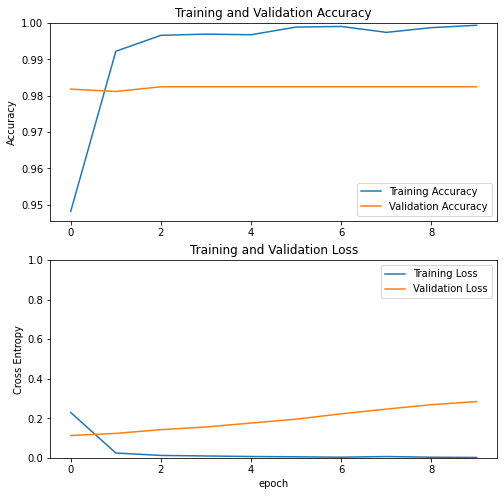

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()